# Definiendo edges_plus_v2

Agrupamos todas las columnas de velocidad en una columna
 

In [1]:
import pandas as pd

df = pd.read_csv("edges_plus.csv")

# Lista de columnas de velocidad
vel_cols = [col for col in df.columns if col.startswith("vel_")]

# Crear vel_max con 50 cuando no hay ningún 1
def obtener_velocidad(row):
    if row[vel_cols].max() == 1:
        col = row[vel_cols].idxmax()
        return int(col.replace("vel_", ""))
    else:
        return 50

df["vel_max"] = df.apply(obtener_velocidad, axis=1)

# Eliminar las columnas antiguas de velocidad
df = df.drop(columns=vel_cols)

df.to_csv("edges_plus_v2.csv", index=False)

df.head()


,u,v,Fallecidos,Graves,Menos_Grav,Leves,Ilesos,Tipo_calle_adoquin,Tipo_calle_asfalto,Tipo_calle_concreto,...,Señal_ceda_el_paso,Señal_pare,Calle_recta,Calle_prioridad_peatones,Calle_principal,Calle_residencial,Calle_secundaria,Calle_terciaria,Largo_calle_norm,vel_max
0,386140,500862085,0,0,0,0,3,0,1,0,...,0,0,0,0,0,0,0,0,0.230906,50
1,386145,386400,0,0,1,3,11,0,1,0,...,0,0,1,0,1,0,0,0,0.636302,50
2,386157,5420440454,0,0,0,1,7,0,0,1,...,0,0,1,0,0,0,0,1,0.483682,0
3,386225,386416,0,1,0,4,10,0,0,1,...,0,0,1,0,1,0,0,0,0.495077,40
4,386226,6310096608,0,2,0,0,6,0,0,1,...,0,0,1,0,0,0,0,1,0.386079,0


Siempre que veamos 0s serán 50

In [ ]:
df["vel_max"] = df["vel_max"].replace(0, 50)
df.to_csv("edges_plus_v2.csv", index=False)

Revisamos que tal esta la  dirsibtucion

In [5]:
import numpy as np
# 4. Crear columna log-transformada del largo de calle
df["Largo_calle_log"] = np.log1p(df["Largo_calle_norm"])

# 5. Eliminar la columna antigua
df = df.drop(columns=["Largo_calle_norm"])

# 6. Guardar dataset actualizado
df.to_csv("edges_plus_v2.csv", index=False)

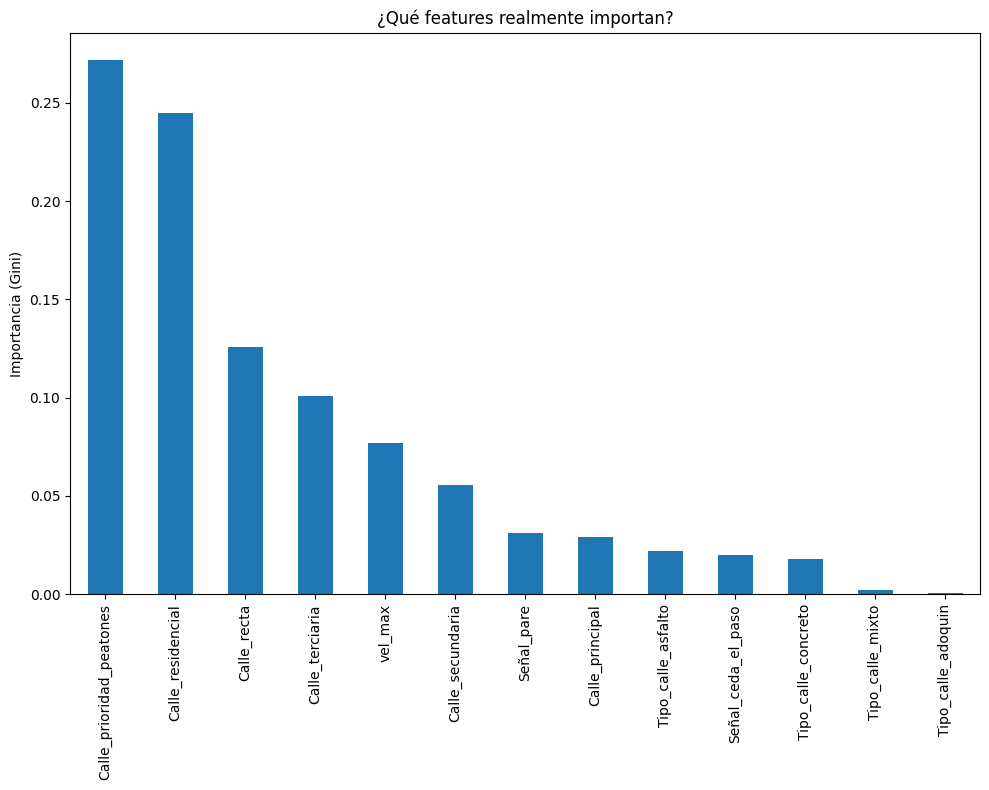

In [7]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd


edge_feature_cols = [
    # tipo de calle
    "Tipo_calle_adoquin",
    "Tipo_calle_asfalto",
    "Tipo_calle_concreto",
    "Tipo_calle_mixto",
    # dirección y señalización
    #"direccion_calle",                                             # LO QUITAMOS CUANDO TRABAJAMOS CON EDGES_PLUS.CSV
    "Señal_ceda_el_paso",
    "Señal_pare",
    # info geométrica / funcional
    "Calle_recta",
    "Calle_prioridad_peatones",
    "Calle_principal",
    "Calle_residencial",
    "Calle_secundaria",
    "Calle_terciaria",
    # velocidades (one-hot)
    "vel_max",
    # largo normalizado
    #"Largo_calle_log"
]



node_feature_cols = ["x_norm", "y_norm", "street_count"]

edges = pd.read_csv("edges_plus_v2.csv")

# ============================
# 2. Ordenar aristas y crear etiqueta de riesgo
# ============================
edges_sorted = edges.sort_values(by=["u", "v"]).reset_index(drop=True)



# Target original (accidentes)
target_cols = ["Fallecidos", "Graves", "Menos_Grav", "Leves", "Ilesos"]

# Severidad "proxy" (puedes ajustar pesos)
edges_sorted["severity_score"] = (
    3 * edges_sorted["Fallecidos"] +
    2 * edges_sorted["Graves"] +
    1 * edges_sorted["Menos_Grav"] +
    0.5 * edges_sorted["Leves"]
)

# Severidad por longitud de calle normalizada
edges_sorted["severity_per_length"] = edges_sorted["severity_score"] / (edges_sorted["Largo_calle_log"] + 1e-6)

# Clases de riesgo (0: bajo, 1: medio, 2: alto) usando terciles
edges_sorted["risk_level"] = pd.qcut(
    edges_sorted["severity_per_length"].rank(method="first"),
    q=3,
    labels=[0, 1, 2]
).astype(int)



# 1. Prepara tus datos tabulares (solo aristas)
# Usa las mismas columnas que usas en edge_attr
X_feat = edges_sorted[edge_feature_cols].fillna(0)
y_target = edges_sorted["risk_level"] # Tu target binario o de 3 clases

# 2. Entrena un modelo rápido
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_feat, y_target)

# 3. Extraer importancia
importances = rf.feature_importances_
feature_names = edge_feature_cols

# Crear DataFrame para visualizar
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)


# 4. Graficar
plt.figure(figsize=(10, 8))
forest_importances.plot.bar()
plt.title("¿Qué features realmente importan?")
plt.ylabel("Importancia (Gini)")
plt.tight_layout()
plt.show()